In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *

In [2]:
%matplotlib inline

In [3]:
myfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/coastal_protection_output_data/"

In [6]:
mydata = pd.read_csv(myfolder+"region_output_WB.csv")

In [7]:
mydata.columns

Index(['locationid', 'locationname', 'rcp', 'ada', 'ssp', 'adacost',
       'riverprotection', 'time', 'rslr', 'par', 'pop_below_h100',
       'seafloodcost', 'riverdike_cost', 'riverdike_maintenance_cost',
       'seadike_cost', 'seadike_maintenance_cost', 'surge_barrier_cost',
       'surge_barrier_maintenance_cost', 'protection_investment_cost',
       'protection_maintenance_cost'],
      dtype='object')

In [8]:
mydata = mydata.set_index(['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection'])

In [9]:
mydata.time.unique()

array([2015, 2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065,
       2070, 2075, 2080, 2085, 2090, 2095, 2100], dtype=int64)

In [10]:
def discount_sum_over_5_years(row,name,d):
    return np.sum([row[name]/5*(1+d)**(1-(year-2015)) for year in np.arange(row["time"]-4,row["time"])])

In [11]:
bigger_data = pd.DataFrame()
for d in [0, 0.03, 0.06, 0.09]:
    for time_horizon in [2035,2055,2105]:
        temp = mydata.copy()
        temp['protection_investment_cost_disc'] = temp.apply(lambda y:discount_sum_over_5_years(y,"protection_investment_cost",d),axis=1)
        temp['protection_maintenance_cost_disc'] = temp.apply(lambda y:discount_sum_over_5_years(y,"protection_maintenance_cost",d),axis=1)
        temp['seafloodcost_disc'] = temp.apply(lambda y:discount_sum_over_5_years(y,"seafloodcost",d),axis=1)
        temp = temp.loc[temp.time<time_horizon,:]
        temp['time_horizon'] = time_horizon
        temp['d'] = d
        bigger_data = bigger_data.append(temp)

In [12]:
newdata = bigger_data.set_index(['time','time_horizon','d'], append=True)[['protection_investment_cost_disc','protection_maintenance_cost_disc','seafloodcost_disc']]

In [112]:
mydata.loc[mydata.time==2015,"protection_investment_cost"].unstack("rcp")["RCP 2.6 (Low ice melting)"].unstack("ada")[["CBA Protection Levels","Constant Protection Levels"]].diff(axis=1)["Constant Protection Levels"].mean(level=["locationid","locationname"])

locationid  locationname              
EAP         East Asia & Pacific          -54003.874651
ECA         Europe & Central Asia          -666.024933
LAC         Latin America & Caribbean     -2887.853852
MNA         Middle East & North Africa    -4482.938798
SAS         South Asia                   -36520.028882
SSA         Sub-Saharan Africa            -9698.404155
YHI         High Income                  -18964.899183
Name: Constant Protection Levels, dtype: float64

In [17]:
newdatacum = newdata.sum(level=['locationid', 'locationname','rcp', 'ada', 'ssp', 'adacost','riverprotection','time_horizon','d'])

In [115]:
newdatacum.protection_investment_cost_disc.unstack("time_horizon")[2035].unstack("d")[0.03].unstack("rcp")["RCP 2.6 (Low ice melting)"].unstack("ada")[["CBA Protection Levels","Constant Protection Levels"]].diff(axis=1)["Constant Protection Levels"].mean(level=["locationid","locationname"])

locationid  locationname              
EAP         East Asia & Pacific          -41450.204556
ECA         Europe & Central Asia          -559.934438
LAC         Latin America & Caribbean     -2073.562864
MNA         Middle East & North Africa    -3170.181685
SAS         South Asia                   -30306.796056
SSA         Sub-Saharan Africa            -8583.317140
YHI         High Income                  -14496.206996
Name: Constant Protection Levels, dtype: float64

In [18]:
newdatacum["tot_cost"] = newdatacum.protection_investment_cost_disc+newdatacum.protection_maintenance_cost_disc

In [15]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [22]:
toplot;

In [94]:
time_horizon = 2035
d = 0.06

explore = newdatacum.reset_index(['time_horizon','d','locationid']).drop('locationid',axis=1)
explore = explore.loc[(explore.time_horizon==time_horizon)&(explore.d==d),['protection_investment_cost_disc']]

explore = explore.stack().unstack("locationname")
explore['world'] = explore.sum(axis=1)

explore = explore.div(explore.world,axis=0)

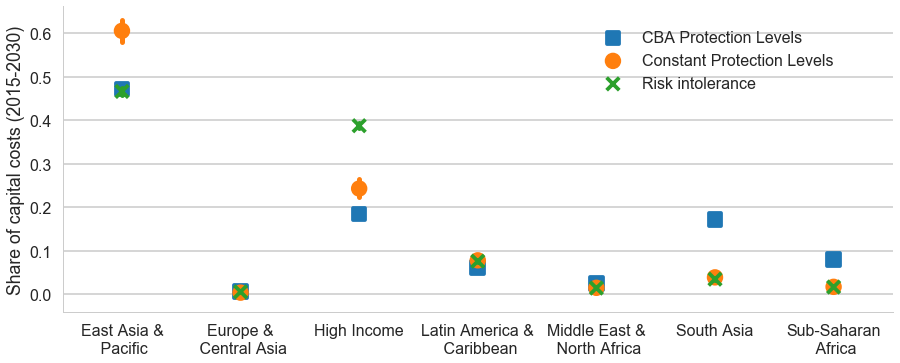

In [96]:
toplot = explore.drop("world",axis=1).stack().reset_index().rename(columns={0:"share"})
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")

g = sns.factorplot(x='locationname',y='share', hue ='ada', data=toplot, kind="point",dodge=False, join=False,\
                   errwidth=5, markers=["s",'o','x'],size=6, aspect=2.2,\
                  legend=False)

g.set_axis_labels("", "Share of capital costs (2015-2030)".format(time_horizon-5,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.7, 0.7), borderaxespad=0.)

plt.savefig("regional_share_invest_{}_{}pc.png".format(time_horizon-5,round(100*d)),ddpi=300,bbox_inches="tight")
plt.savefig("regional_share_invest_{}_{}pc.pdf".format(time_horizon-5,round(100*d)))

In [97]:
explore.drop("world",axis=1).mean(level=['ada'])

locationname,East Asia & Pacific,Europe & Central Asia,High Income,Latin America & Caribbean,Middle East & North Africa,South Asia,Sub-Saharan Africa
ada,,,,,,,
CBA Protection Levels,0.471992,0.005340,0.184007,0.061666,0.024888,0.172162,0.079946
Constant Abs. Flood Risk,0.574570,0.005095,0.268480,0.081103,0.014394,0.037409,0.018948
Constant Protection Levels,0.605990,0.003389,0.243023,0.077779,0.014519,0.038537,0.016763
Constant Rel. Flood Risk,0.645346,0.004024,0.202616,0.074900,0.014164,0.040704,0.018246
Risk intolerance,0.466566,0.005398,0.387609,0.075793,0.013931,0.034403,0.016300


In [72]:
time_horizon = 2105
d = 0.03

share_risk = newdatacum.reset_index(['time_horizon','d','locationid']).drop('locationid',axis=1)
share_risk = share_risk.loc[(share_risk.time_horizon==time_horizon)&(share_risk.d==d),['seafloodcost_disc']]

share_risk = share_risk.stack().unstack("locationname")
share_risk['world'] = share_risk.sum(axis=1)

share_risk = share_risk.div(share_risk.world,axis=0)

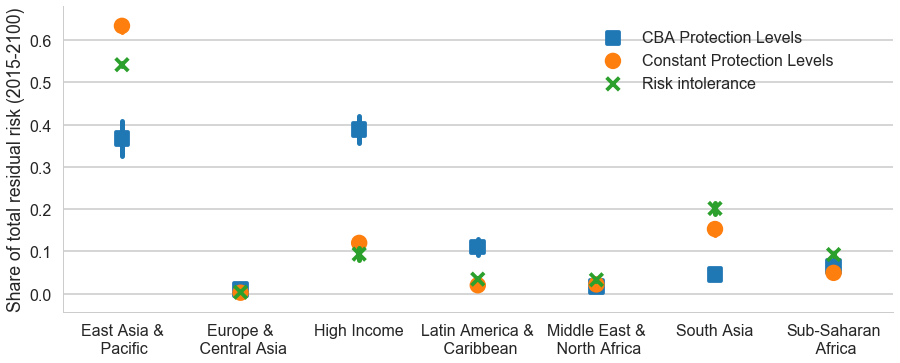

In [73]:
toplot = share_risk.drop("world",axis=1).stack().reset_index().rename(columns={0:"share"})
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n").str.replace("Saharan","Saharan\n")

g = sns.factorplot(x='locationname',y='share', hue ='ada', data=toplot, kind="point",dodge=False, join=False,\
                   errwidth=5, markers=["s",'o','x'],ci='sd', size=6, aspect=2.2,\
                  legend=False)

g.set_axis_labels("", "Share of total residual risk (2015-{})".format(time_horizon-5,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.7, 0.7), borderaxespad=0.)

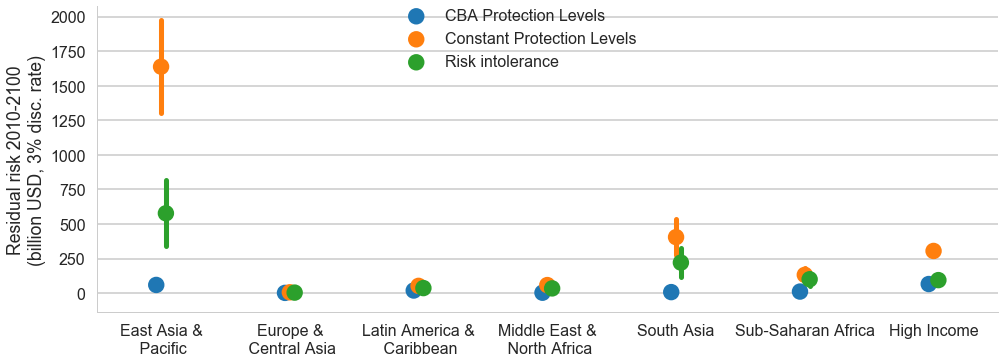

In [77]:
time_horizon = 2105
d = 0.03

toplot = newdatacum.reset_index(['time_horizon','d'])
toplot = toplot.loc[(toplot.time_horizon==time_horizon)&(toplot.d==d),['seafloodcost_disc']]
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot['seafloodcost_disc'] = 10**(-3)*toplot.seafloodcost_disc
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n")

g = sns.factorplot(x='locationname',y='seafloodcost_disc', hue= 'ada', data=toplot, kind="point",ci='sd',dodge=True,join=False, size=6, aspect=2.4,\
                  legend=False)

g.set_axis_labels("", "Residual risk 2010-{}\n(billion USD, {}% disc. rate)".format(time_horizon-5,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.75), borderaxespad=0.)

#plt.savefig("coastal_{}_{}pc.png".format(time_horizon-5,round(100*d)),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_{}_{}pc.pdf".format(time_horizon-5,round(100*d)))

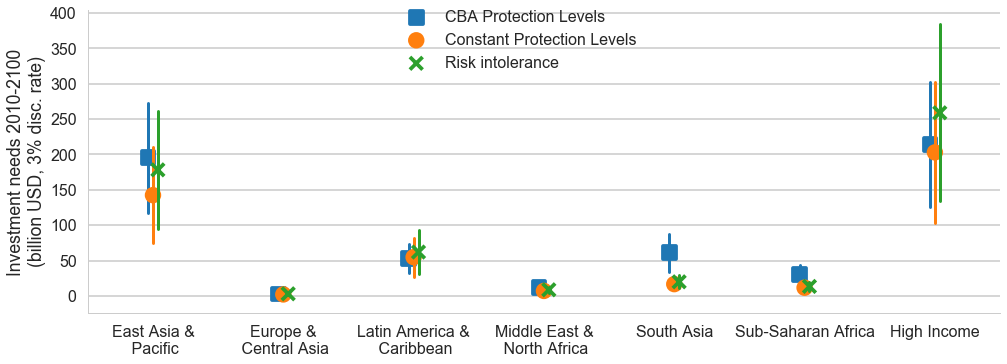

In [80]:
time_horizon = 2105
d = 0.03

toplot = newdatacum.reset_index(['time_horizon','d'])
toplot = toplot.loc[(toplot.time_horizon==time_horizon)&(toplot.d==d),['tot_cost']]
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot['tot_cost'] = 10**(-3)*toplot.tot_cost
toplot['locationname'] = toplot['locationname'].str.replace('&',"&\n")

g = sns.factorplot(x='locationname',y='tot_cost', hue= 'ada', data=toplot, kind="point",ci='sd',dodge=True,join=False, size=6, aspect=2.4,\
                  errwidth=3, markers=["s",'o','x'],legend=False)

g.set_axis_labels("", "Investment needs 2010-{}\n(billion USD, {}% disc. rate)".format(time_horizon-5,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.75), borderaxespad=0.)

#plt.savefig("coastal_{}_{}pc.png".format(time_horizon-5,round(100*d)),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_{}_{}pc.pdf".format(time_horizon-5,round(100*d)))

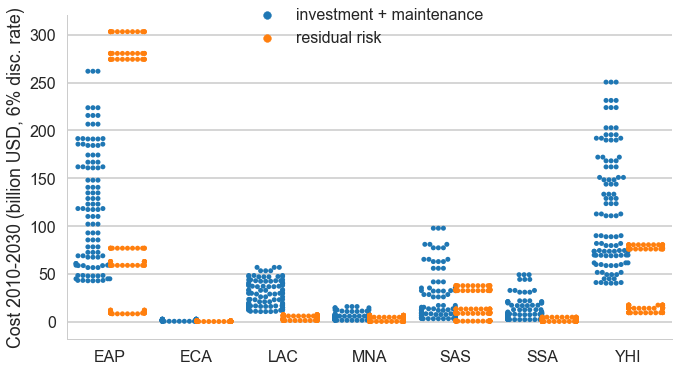

In [23]:
time_horizon = 2035
d = 0.06

toplot = newdatacum.reset_index(['time_horizon','d'])
toplot = toplot.loc[(toplot.time_horizon==time_horizon)&(toplot.d==d),['tot_cost','seafloodcost_disc']]
toplot.columns.name="costtype"
toplot = toplot.stack()
toplot.name = "value"
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot['value'] = 10**(-3)*toplot.value

g = sns.factorplot(x='locationid',y='value', hue= 'costtype', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False)

g.set_axis_labels("", "Cost 2010-{} (billion USD, {}% disc. rate)".format(time_horizon-5,round(100*d)))
g.add_legend(title="",bbox_to_anchor=(0.5, 0.8), borderaxespad=0.)

#plt.savefig("coastal_{}_{}pc.png".format(time_horizon-5,round(100*d)),ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_{}_{}pc.pdf".format(time_horizon-5,round(100*d)))

In [317]:
newdatacum['all_costs'] = newdatacum[['tot_cost','seafloodcost_disc']].sum(axis=1)

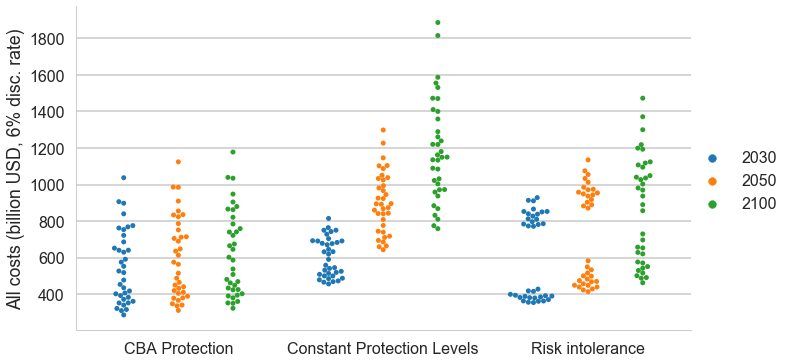

In [287]:
d = 0.06

toplot = newdatacum.reset_index()
toplot = toplot.loc[(toplot.d==d),:]
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot["time_horizon"] = toplot.time_horizon.replace({2035:2030,2055:2050,2105:2100})
toplot['all costs'] = 10**(-3)*toplot['all costs']

g = sns.factorplot(x='ada',y='all costs', hue= 'time_horizon', data=toplot, kind="swarm",dodge=True, size=6, aspect=1.7,\
                  legend=False)

g.set_axis_labels("", "All costs (billion USD, {}% disc. rate)".format(round(100*d)))
g.add_legend(title="")

plt.savefig("coastal_allcosts_{}pc.png".format(round(100*d)),ddpi=300,bbox_inches="tight")
plt.savefig("coastal_allcosts_{}pc.pdf".format(round(100*d)))

In [301]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [325]:
def drivers_from_anova(varin,mydata):
    formula=varin+" ~ rcp+ssp+adacost+riverprotection+ada"
    olsmodel=ols(formula,data=mydata).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
    table=table.sort_values(by=['sum_sq'],ascending=False)
    sumvar=0
    drivers=list()
    for var in table.index:
        if var!='Residual':
            drivers.append(var)
            sumvar+=table.loc[var,'sum_sq_pc']
        if len(drivers)==3:
            break
    return drivers,sumvar

In [326]:
for (time),subframe in newdatacum.reset_index('d').loc[newdatacum.reset_index('d').d==0.03,:].groupby(level=["time_horizon"]):
    drivers,sumvar = drivers_from_anova("tot_cost",subframe.reset_index())
    print(time,drivers,sumvar)

2035 ['adacost', 'ada', 'riverprotection'] 0.88960406054
2055 ['adacost', 'ada', 'rcp'] 0.908052141858
2105 ['adacost', 'ada', 'rcp'] 0.92309249683


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [327]:
for (time),subframe in newdatacum.reset_index('d').loc[newdatacum.reset_index('d').d==0.03,:].groupby(level=["time_horizon"]):
    drivers,sumvar = drivers_from_anova("seafloodcost_disc",subframe.reset_index())
    print(time,drivers,sumvar)

2035 ['ada', 'rcp', 'ssp'] 0.993206819106
2055 ['ada', 'ssp', 'rcp'] 0.964578853967
2105 ['ada', 'rcp', 'ssp'] 0.896475219602


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [328]:
for (time),subframe in newdatacum.reset_index('d').loc[newdatacum.reset_index('d').d==0.03,:].groupby(level=["time_horizon"]):
    drivers,sumvar = drivers_from_anova("all_costs",subframe.reset_index())
    print(time,drivers,sumvar)

2035 ['adacost', 'ada', 'rcp'] 0.86429449855
2055 ['ada', 'adacost', 'rcp'] 0.891986822397
2105 ['ada', 'rcp', 'ssp'] 0.838985879339


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [332]:
diff = newdatacum['all_costs'].unstack("ada")[['Constant Protection Levels','Risk intolerance']].diff(axis=1)

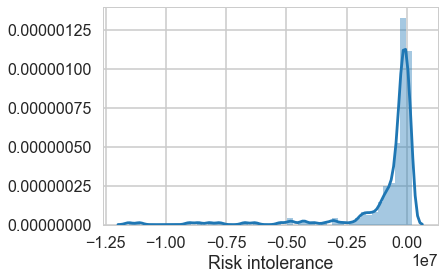

In [333]:
sns.distplot(diff['Risk intolerance'])

In [334]:
sum(diff['Risk intolerance']>0)/sum(diff['Risk intolerance']<0)

0.29729729729729731

In [335]:
forprim = diff['Risk intolerance'].reset_index()

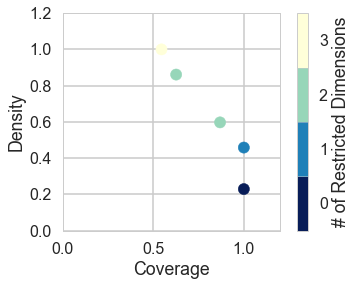

In [337]:
p = prim.Prim(forprim[['rcp', 'ssp', 'adacost','riverprotection','time_horizon','d']], forprim['Risk intolerance'],\
              threshold=0.0001, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [339]:
box.select(3)
print(box.coverage,box.density)
box.limits

0.626262626263 0.861111111111


,min,max,qp values
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},4.449371e-14
time_horizon,2035,2035,1.322525e-12


In [49]:
oois = ['tot_cost','seafloodcost_disc']

data = np.array([[newdatacum[oois[0]][0],newdatacum[oois[1]][0]]])
for i in range(1,len(newdatacum.index)):
    data = np.concatenate((data,np.array([[newdatacum[oois[0]][i],newdatacum[oois[1]][i]]])))

data_norm = normalize(data)

In [50]:
inputs = newdatacum.reset_index()[['rcp', 'ada', 'ssp', 'adacost','riverprotection']]

In [54]:
n_clusters = 6
f_value = 0.5
seuil = 1.2

In [55]:
dummy = get_prim(n_clusters, f_value, data,oois[0],oois[1],inputs,data_norm)
boxes = dummy[0]
df = dummy[1]

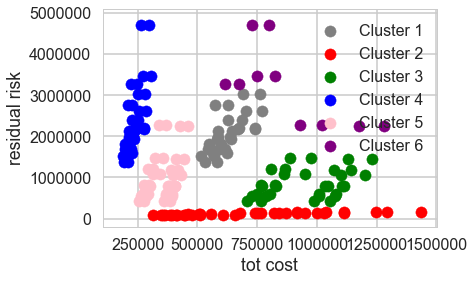

In [56]:
mycolors = ["grey","red","green","blue","pink","purple"]
for (i,subdf) in df.groupby("class"):

    plt.scatter(subdf.tot_cost,subdf.seafloodcost_disc,label="Cluster {}".format(i),c=mycolors[i-1])
plt.legend()
plt.xlabel("tot cost")
plt.ylabel("residual risk")

In [57]:
boxes[0].limits

,min,max,qp values
ada,"{Constant Protection Levels, Constant Rel. Flo...","{Constant Protection Levels, Constant Rel. Flo...",9.175853e-10
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},3.477975e-07


In [58]:
boxes[1].limits

,min,max,qp values
ada,{CBA Protection},{CBA Protection},6.871948e-26


In [59]:
boxes[2].limits

,min,max,qp values
ada,"{Constant Abs. Flood Risk, Risk intolerance}","{Constant Abs. Flood Risk, Risk intolerance}",4.628203e-11
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},3.328461e-08


In [60]:
boxes[3].limits

,min,max,qp values
ada,"{Constant Protection Levels, Constant Rel. Flo...","{Constant Protection Levels, Constant Rel. Flo...",4.722366e-15
adacost,{Low Adaptation Unit Cost},{Low Adaptation Unit Cost},1.455192e-11


In [61]:
boxes[4].limits

,min,max,qp values
ada,"{Constant Abs. Flood Risk, Risk intolerance}","{Constant Abs. Flood Risk, Risk intolerance}",4.722366e-15
adacost,{Low Adaptation Unit Cost},{Low Adaptation Unit Cost},1.455192e-11


In [62]:
boxes[5].limits

,min,max,qp values
ssp,{SSP5},{SSP5},0.000352
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},0.009780
rcp,"{RCP 8.5 (High ice melting), RCP 4.5 (Medium i...","{RCP 8.5 (High ice melting), RCP 4.5 (Medium i...",0.076404
ada,"{Constant Abs. Flood Risk, Constant Protection...","{Constant Abs. Flood Risk, Constant Protection...",0.227249


In [65]:
forprim = newdatacum[['tot_cost','seafloodcost_disc']].sum(axis=1).reset_index().rename(columns={0:"all_costs"})

In [67]:
forprim.all_costs.describe()

count    1.800000e+02
mean     1.956612e+06
std      1.039750e+06
min      4.119737e+05
25%      1.139432e+06
50%      1.856185e+06
75%      2.577746e+06
max      5.510730e+06
Name: all_costs, dtype: float64

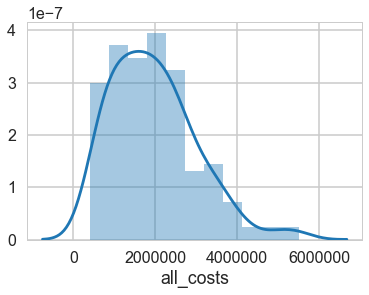

In [68]:
sns.distplot(forprim.all_costs)

In [72]:
forprim.ada.unique()

array(['CBA Protection', 'Constant Abs. Flood Risk',
       'Constant Protection Levels', 'Constant Rel. Flood Risk',
       'Risk intolerance'], dtype=object)

In [74]:
adadict = {'CBA Protection':'CBA', 'Constant Abs. Flood Risk':"c_abs",
       'Constant Protection Levels':'c', 'Constant Rel. Flood Risk':'c_rel',
       'Risk intolerance':'int'}

In [75]:
forprim['ada'] = forprim.ada.replace(adadict)

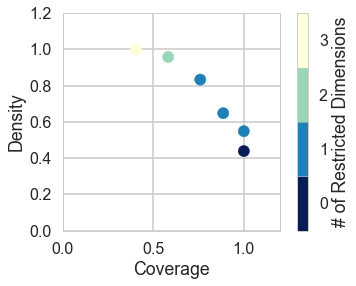

In [87]:
p = prim.Prim(forprim[['rcp', 'ada', 'ssp', 'adacost','riverprotection']], forprim.all_costs,\
              threshold=2.0e+06, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [88]:
box.select(3)
print(box.coverage,box.density)
box.limits

0.759493670886 0.833333333333


,min,max,qp values
ada,"{c_rel, c}","{c_rel, c}",6.131459e-12


In [177]:
diff = newdatacum.tot_cost.unstack("ada")[['Risk intolerance','CBA Protection']].diff(axis=1)

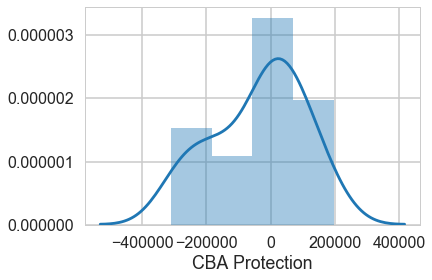

In [178]:
sns.distplot(diff['CBA Protection'])

In [168]:
forprim=diff['CBA Protection'].reset_index()

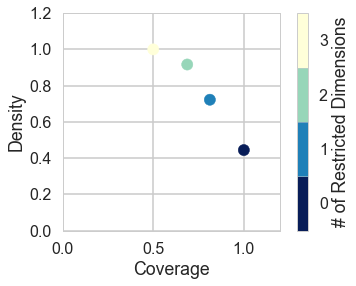

In [179]:
p = prim.Prim(forprim[['rcp', 'ssp', 'adacost','riverprotection']], forprim['CBA Protection'],\
              threshold=1, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [180]:
box.select(1)
print(box.coverage,box.density)
box.limits

0.8125 0.722222222222


,min,max,qp values
adacost,{Low Adaptation Unit Cost},{Low Adaptation Unit Cost},0.016242


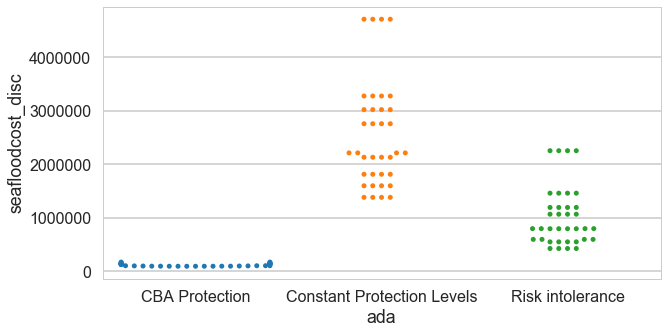

In [248]:
toplot = newdatacum.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]

fig, ax = plt.subplots()
sns.swarmplot(x='ada',y='seafloodcost_disc',data=toplot,ax=ax)
fig.set_size_inches(10, 5)

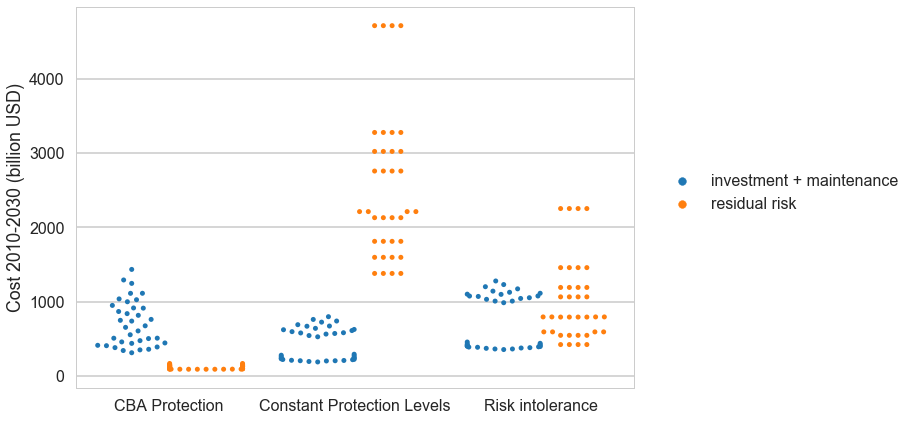

In [251]:
toplot = newdatacum[['tot_cost','seafloodcost_disc']]
toplot.columns.name="costtype"
toplot = toplot.stack()
toplot.name = "value"
toplot = toplot.reset_index()
toplot = toplot.loc[(toplot.ada!='Constant Abs. Flood Risk')&(toplot.ada!='Constant Rel. Flood Risk'),:]
toplot["costtype"] = toplot["costtype"].replace({'tot_cost':'investment + maintenance','seafloodcost_disc':'residual risk'})
toplot['value'] = 10**(-3)*toplot.value

fig, ax = plt.subplots()
#sns.factorplot(x='ada',y='value', hue= 'costtype', data=toplot, kind="point",ax=ax, join=False, legend_out=True)
sns.swarmplot(x='ada',y='value', hue= 'costtype', data=toplot,ax=ax, dodge=True)
fig.set_size_inches(10, 7)
ax.set_xlabel("")
ax.set_ylabel("Cost 2010-2030 (billion USD)")
plt.legend(title="",bbox_to_anchor=(1.5, 0.6))

#plt.savefig("coastal_2030_3pc.png",ddpi=300,bbox_inches="tight")
#plt.savefig("coastal_2030_3pc.pdf")

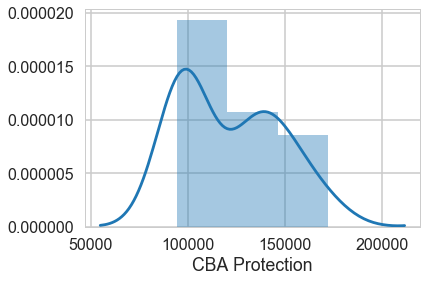

In [187]:
sns.distplot(newdatacum.seafloodcost_disc.unstack("ada")['CBA Protection'])

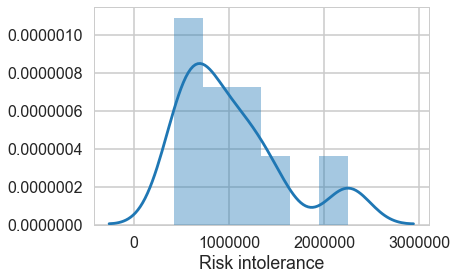

In [186]:
sns.distplot(newdatacum.seafloodcost_disc.unstack("ada")['Risk intolerance'])

In [191]:
forprim = newdatacum.seafloodcost_disc.unstack("ada")['CBA Protection'].reset_index()

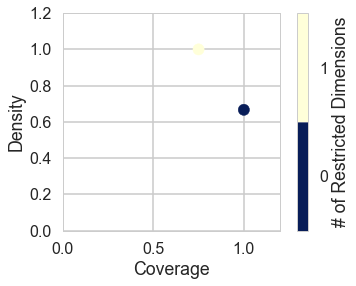

In [193]:
p = prim.Prim(forprim[['rcp', 'ssp', 'adacost','riverprotection']], forprim['CBA Protection'],\
              threshold=100000, threshold_type=">")

box = p.find_box()
box.show_tradeoff();

In [194]:
box.select(1)
print(box.coverage,box.density)
box.limits

0.75 1.0


,min,max,qp values
adacost,{High Adaptation Unit Cost},{High Adaptation Unit Cost},0.000677
